In this notebook I am performing **DATA CLEANING & FEATURE ENGINEERING** on the [`houses`](../../data/houses.csv) dataset.

In [1]:
from ast import literal_eval

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data/houses.csv')
print(df.shape)
df.head(3)

(1044, 21)


property_name  \
0    5 Bedroom House for sale in Sector 70A Gurgaon   
1  5 Bedroom House for sale in Sector 21A Faridabad   
2  10 Bedroom House for sale in Sushant Lok Phase 1   

                                                link           society  \
0  https://www.99acres.com/5-bhk-bedroom-independ...  Bptp Visionnaire   
1  https://www.99acres.com/5-bhk-bedroom-independ...               NaN   
2  https://www.99acres.com/10-bhk-bedroom-indepen...               NaN   

        price              rate                   area  \
0  5.25 Crore   ₹ 20,115/sq.ft.  (242 sq.m.) Plot Area   
1   5.7 Crore  ₹ 105,751/sq.ft.   (50 sq.m.) Plot Area   
2   2.1 Crore   ₹ 38,251/sq.ft.   (51 sq.m.) Plot Area   

                  areaWithType      bedRoom      bathroom       balcony  ...  \
0  Plot area 290(242.48 sq.m.)   5 Bedrooms   4 Bathrooms  3+ Balconies  ...   
1   Plot area 539(50.07 sq.m.)   5 Bedrooms   4 Bathrooms   2 Balconies  ...   
2       Plot area 61(51 sq.m.)  10 Bedrooms  10 Bathrooms  3+ Balconies  ...   

                                     address noOfFloor      facing  \
0  29b, Sector 70A Gurgaon, Gurgaon, Haryana  3 Floors  North-East   
1     Sector 21A Faridabad, Gurgaon, Haryana  2 Floors         NaN   
2      Sushant Lok Phase 1, Gurgaon, Haryana  5 Floors        West   

      agePossession                                    nearbyLocations  \
0   0 to 1 Year Old  ['Good Earth City Center 2', 'Kunskapsskolan I...   
1  5 to 10 Year Old                                                NaN   
2   0 to 1 Year Old  ['Sector 42-43 metro station', 'Huda city cent...   

                                         description  \
0  Do you wish to buy an independent house in sec...   
1  Hi, we have an independent house/villa availab...   
2  Monthly rental income is rs1,40,000/- Best opt...   

                                      furnishDetails  \
0  ['1 Wardrobe', '1 Fan', '1 Exhaust Fan', '1 Ge...   
1  ['1 Water Purifier', '5 Fan', '1 Exhaust Fan',...   
2  ['10 Bed', '3 Fan', '10 Geyser', '2 Light', 'N...   

                                            features  \
0  ['Feng Shui / Vaastu Compliant', 'Private Gard...   
1  ['Private Garden / Terrace', 'Park', 'Visitor ...   
2  ['Maintenance Staff', 'Water Storage', 'Visito...   

                                              rating property_id  
0  ['Environment5 out of 5', 'Lifestyle4 out of 5...   K70037724  
1                                                NaN   E69288322  
2  ['Environment5 out of 5', 'Lifestyle5 out of 5...   F69536898  

[3 rows x 21 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   property_name    1044 non-null   object
 1   link             1044 non-null   object
 2   society          453 non-null    object
 3   price            968 non-null    object
 4   rate             1005 non-null   object
 5   area             1044 non-null   object
 6   areaWithType     987 non-null    object
 7   bedRoom          987 non-null    object
 8   bathroom         987 non-null    object
 9   balcony          987 non-null    object
 10  additionalRoom   589 non-null    object
 11  address          1031 non-null   object
 12  noOfFloor        967 non-null    object
 13  facing           674 non-null    object
 14  agePossession    987 non-null    object
 15  nearbyLocations  913 non-null    object
 16  description      1036 non-null   object
 17  furnishDetails   743 non-null    

In [4]:
df.isnull().sum()

property_name        0
link                 0
society            591
price               76
rate                39
area                 0
areaWithType        57
bedRoom             57
bathroom            57
balcony             57
additionalRoom     455
address             13
noOfFloor           77
facing             370
agePossession       57
nearbyLocations    131
description          8
furnishDetails     301
features           370
rating             137
property_id          8
dtype: int64

## General steps

In [5]:
df = df.applymap(lambda x: str.lower(x) if isinstance(x, str) else x)

## price

In [6]:
df['price'].str.split().str.get(-1).unique()

array(['crore', 'lac', nan, 'request'], dtype=object)

In [7]:
drop_rows = df[df['price'].str.contains('request') == True].index
df.drop(index=drop_rows, inplace=True)

In [8]:
def handle_price(x: str) -> float:
    if isinstance(x, float):
        return x

    if 'crore' in x:
        return float(x.split(' ')[0]) * 100

    return float(x.split(' ')[0])

In [9]:
df['price'] = df['price'].apply(handle_price)

## rate

In [10]:
df[df['rate'].str.contains('sq.ft.') == False]

Empty DataFrame
Columns: [property_name, link, society, price, rate, area, areaWithType, bedRoom, bathroom, balcony, additionalRoom, address, noOfFloor, facing, agePossession, nearbyLocations, description, furnishDetails, features, rating, property_id]
Index: []

[0 rows x 21 columns]

In [11]:
df['rate'] = df['rate'].str.replace(',', '').str.extract(r'(\d+)/sq.ft.').astype(float)

## area

In [12]:
df[df['area'].str.contains('sq.m.') == False]

Empty DataFrame
Columns: [property_name, link, society, price, rate, area, areaWithType, bedRoom, bathroom, balcony, additionalRoom, address, noOfFloor, facing, agePossession, nearbyLocations, description, furnishDetails, features, rating, property_id]
Index: []

[0 rows x 21 columns]

**`area` in the dataset has _sq.m._ unit but we require _sq.ft._ unit. So I am going to convert it into _sq.ft._ unit.**

In [13]:
df['area'] = (
    df['area'].str.extract(r'(\d+) sq.m.').astype(float).apply(lambda x: x * 10.76)
)  # convert into (sq. ft.)

## areaWithType

In [14]:
df[df['areaWithType'].str.contains('super') == True].shape[0]

0

In [15]:
df[df['areaWithType'].str.contains('built') == True].shape[0]

291

In [16]:
df[df['areaWithType'].str.contains('carpet') == True].shape[0]

184

In [17]:
df[df['areaWithType'].str.contains('built') == True]['areaWithType'].values[:10]

array(['plot area 84(70.23 sq.m.)built up area: 83 sq.yards (69.4 sq.m.)carpet area: 82 sq.yards (68.56 sq.m.)',
       'built up area: 6382 (592.91 sq.m.)',
       'built up area: 8000 (743.22 sq.m.)',
       'plot area 215(179.77 sq.m.)built up area: 215 sq.yards (179.77 sq.m.)',
       'built up area: 267 (223.25 sq.m.)',
       'plot area 2700(250.84 sq.m.)built up area: 4000 sq.ft. (371.61 sq.m.)',
       'plot area 272(25.27 sq.m.)built up area: 4800 sq.ft. (445.93 sq.m.)carpet area: 3500 sq.ft. (325.16 sq.m.)',
       'plot area 2400(222.97 sq.m.)built up area: 3400 sq.ft. (315.87 sq.m.)carpet area: 3000 sq.ft. (278.71 sq.m.)',
       'plot area 250(209.03 sq.m.)built up area: 267 sq.yards (223.25 sq.m.)',
       'built up area: 6000 (557.42 sq.m.)'], dtype=object)

In [18]:
# Extract plot area, built up area, carpet area

df['plot_area'] = df['areaWithType'].str.extract(r'plot area\W(\d+)')
df['built_up_area'] = df['areaWithType'].str.extract(r'built up area\W+(\d+)')
df['carpet_area'] = df['areaWithType'].str.extract(r'carpet area\W+(\d+)')

Here, many rows contains **sq.yards**, some contains **sq.m.** units and some **sq.ft.** unit which make the area column inconsistent. We need to tackle it in `FEATURE ENGINEERING` part.

## bedRoom, bathroom, balcony

In [19]:
cols = ['bedRoom', 'bathroom', 'balcony']

for col in cols:
    print(f'{col}: {df[col].unique()}')
    print()

bedRoom: ['5 bedrooms' '10 bedrooms' '21 bedrooms' '12 bedrooms' '20 bedrooms'
 '16 bedrooms' '6 bedrooms' '3 bedrooms' '4 bedrooms' '13 bedrooms'
 '9 bedrooms' '7 bedrooms' '2 bedrooms' '8 bedrooms' nan '1 bedroom'
 '18 bedrooms' '19 bedrooms' '36 bedrooms' '34 bedrooms' '14 bedrooms'
 '11 bedrooms']

bathroom: ['4 bathrooms' '10 bathrooms' '21 bathrooms' '12 bathrooms' '20 bathrooms'
 '5 bathrooms' '16 bathrooms' '6 bathrooms' '3 bathrooms' '7 bathrooms'
 '13 bathrooms' '9 bathrooms' '2 bathrooms' '1 bathroom' '18 bathrooms'
 '8 bathrooms' nan '17 bathrooms' '36 bathrooms' '34 bathrooms'
 '14 bathrooms' '11 bathrooms']

balcony: ['3+ balconies' '2 balconies' '1 balcony' '3 balconies' nan 'no balcony']



In [20]:
for col in cols:
    df[col] = df[col].str.split(' ').str.get(0)

In [21]:
df['balcony'] = df['balcony'].replace('3+', '-1').str.replace('no', '0')

**Encodings:**

- `0` >> **No**
- `-1` >> **3+**

In [22]:
for col in cols:
    df[col] = df[col].astype(float)

## additionalRoom

In [23]:
df['additionalRoom'].value_counts()[:10]

additionalRoom
servant room                                     82
pooja room,study room,servant room,store room    63
others                                           59
pooja room                                       38
pooja room,study room,servant room               34
pooja room,study room,servant room,others        32
store room                                       31
pooja room,servant room                          24
study room                                       19
study room,servant room                          19
Name: count, dtype: int64

In [24]:
additionalRooms = ['study room', 'servant room', 'store room', 'pooja room', 'others']

for col in additionalRooms:
    df[col] = df['additionalRoom'].str.contains(col).fillna(0).astype(int)

In [25]:
df.sample(5)[['additionalRoom', 'study room', 'servant room', 'store room', 'pooja room', 'others']]

additionalRoom  study room  servant room  \
611                      study room,store room           1             0   
982         pooja room,study room,servant room           1             1   
270                                        NaN           0             0   
228  pooja room,study room,servant room,others           1             1   
180                                     others           0             0   

     store room  pooja room  others  
611           1           0       0  
982           0           1       0  
270           0           0       0  
228           0           1       1  
180           0           0       1

## address, description, property_name `->>` sector

In [26]:
df['property_name'].fillna('', inplace=True)
df['address'].fillna('', inplace=True)
df['description'].fillna('', inplace=True)

In [27]:
df.shape

(1034, 29)

In [28]:
df['temp_sector'] = df['address'].add(' ').add(df['description']).add(' ').add(df['property_name'])

In [29]:
df['sector'] = df['temp_sector'].str.replace(r'\W+', ' ', regex=True).str.extract(r'(sector \d+\w)')

**Deal with `property` which does not contains any sector number**

In [30]:
no_sector_series = df[df['temp_sector'].str.contains('sector') == False]['temp_sector']
no_sector_series.shape

(480,)

In [31]:
extra_sectors_naming = {
    '46b': 'sector 46b',
    'dharam colony': 'sector 12',
    'krishna colony': 'sector 7',
    'suncity': 'sector 54',
    'prem nagar': 'sector 13',
    'mg road': 'sector 28',
    'gandhi nagar': 'sector 28',
    'laxmi garden': 'sector 11',
    'shakti nagar': 'sector 11',
    'baldev nagar': 'sector 7',
    'shivpuri': 'sector 7',
    'garhi harsaru': 'sector 17',
    'adarsh nagar': 'sector 12',
    'shivaji nagar': 'sector 11',
    'bhim nagar': 'sector 6',
    'madanpuri': 'sector 7',
    'saraswati vihar': 'sector 28',
    'arjun nagar': 'sector 8',
    'ravi nagar': 'sector 9',
    'vishnu garden': 'sector 105',
    'bhondsi': 'sector 11',
    'surya vihar': 'sector 21',
    'devilal colony': 'sector 9',
    'valley view estate': 'sector 54',
    'mehrauli  road': 'sector 14',
    'jyoti park': 'sector 7',
    'ansal plaza': 'sector 23',
    'dayanand colony': 'sector 6',
    'sushant lok phase 2': 'sector 55',
    'chakkarpur': 'sector 28',
    'greenwood city': 'sector 45',
    'subhash nagar': 'sector 12',
    'malibu town': 'sector 47',
    'surat nagar 1': 'sector 104',
    'mianwali colony': 'sector 12',
    'jacobpura': 'sector 12',
    'rajiv nagar': 'sector 13',
    'rajiv colony': 'sector 33',
    'ashok vihar': 'sector 3',
    'dlf phase 1': 'sector 26',
    'dlf phase 2': 'sector 25',
    'dlf phase 3': 'sector 24',
    'dlf phase 4': 'sector 28',
    'dlf phase 5': 'sector 43',
    'sushant lok phase 3': 'sector 57',
    'sikanderpur metro': 'sector 26',
    'nirvana country': 'sector 50',
    'palam vihar': 'sector 2',
    'new palam vihar': 'sector 110',
    'sushant lok phase 1': 'sector 43',
    'laxman vihar': 'sector 4',
    'laxman vihar phase 2': 'sector 4',
    'rajendra park': 'sector 105',
    'uppals southend': 'sector 49',
    'sohna': 'sector 33',
    'ashok vihar phase 3 extension': 'sector 5',
    'south city 1': 'sector 41',
    'ashok vihar phase 2': 'sector 5',
    "garauli kalan": 'sector 45',
    "bhawani enclave": 'sector 56',
    "iffco chowk": 'sector 29',
    'sai kunj': 'sector 110a',
    'manesar': 'sector 4',
    'shankar vihar': 'sector 104',
    'patel nagar': 'sector 15',
    'dwarka expressway': 'sector 88a',
    'gwal pahari': 'sector 2',
    'paras quartier': 'sector 29',
    'ambience island': 'sector 24',
    'lajpat nagar': 'sector 29',
    'mehrauli': 'sector 29',
    'central park flower valley': 'sector 32',
}

In [32]:
def handle_sector(x: str) -> str | float:
    if not x:
        return np.nan

    for k, v in extra_sectors_naming.items():
        if k in x:
            return v
    else:
        return np.nan

In [33]:
df.loc[no_sector_series.index, 'sector'] = df['temp_sector'].apply(handle_sector)

df['sector'].isnull().sum()

130

**These many value are left to categories with sectors.**

## noOfFloors

In [34]:
df['noOfFloor'].unique()

array(['3 floors', '2 floors', '5 floors', '4 floors', nan, '1 floors',
       '02 floors', '14 floors', '21 floors', '0 floors', '12 floors',
       '27 floors', '13 floors', '6 floors', '10 floors', '20 floors',
       '11 floors', '41 floors', '51 floors', '16 floors', '33 floors'],
      dtype=object)

In [35]:
df['noOfFloor'] = df['noOfFloor'].str.extract(r'(\d+) ').astype(float)

## facing

In [36]:
df['facing'].unique()

array(['north-east', nan, 'west', 'north', 'east', 'south-west', 'south',
       'south-east', 'north-west'], dtype=object)

**`facing` is all good column. There is no need to clean.**

## agePossession

In [37]:
df['agePossession'].unique()

array(['0 to 1 year old', '5 to 10 year old', '1 to 5 year old',
       'within 6 months', '10+ year old', 'undefined', nan, 'jun 2024',
       'dec 2023', 'by 2027', 'under construction', 'oct 2024', 'by 2024',
       'dec 2024', 'within 3 months', 'oct 2023', 'jan 2024'],
      dtype=object)

In [38]:
def categorize_age_possession(value: str) -> str:
    if pd.isna(value):
        return "undefined"
    elif "0 to 1 year old" == value or "within 6 months" == value or "within 3 months" == value:
        return "new property"
    elif "1 to 5 year old" == value:
        return "Relatively New"
    elif "5 to 10 year old" == value:
        return "moderately old"
    elif "10+ year old" == value:
        return "old property"
    elif "under construction" == value or "by" in value:
        return "under construction"

    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])  # <<- Raises ValueError
        return "under construction"
    except ValueError:
        return "undefined"

In [39]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [40]:
df['agePossession'].value_counts()

agePossession
moderately old        256
Relatively New        229
old property          219
undefined             199
new property          119
under construction     12
Name: count, dtype: int64

## nearbyLocations

In [41]:
df['nearbyLocations'].isnull().sum()

124

In [42]:
df['nearbyLocations'] = df['nearbyLocations'].apply(
    lambda x: '[]' if isinstance(x, float) else literal_eval(x)
)

In [43]:
df['nearbyLocations'].explode().nunique()

938

In [44]:
df['nearbyLocations'].explode().sample(50).values

array(['bhatnagar maternity and nursing home', 'icici bank',
       'taneja hospital', 'park hospital gurgaon',
       'best urologist atcomplete family clinic',
       'sharma hospital gurgaon', 'the god father',
       'kailash nursing home gurgaon',
       'indira gandhi international airport',
       'shree krishna hospital gurgaon', 'karur vysay bank', 'tocpao',
       'neelkanth health care', 'icici bank atm',
       'dentecare - multispeciality dental clinic', 'vatsalya clinic',
       'mamta hospital gurgaon', 'guardian pharmacy', 'dhabba',
       'pvr cinames', 'hdfc bank', 'om sweets', 'icici bank atm',
       'sethi hospital gurgaon', 'st. michaels sr. sec. school',
       'basai dhankot railway station', 'bones clinic - orthopaedics',
       'standard chartered bank', 'hdfc bank atm', 'axis bank atm',
       'sapphire mall', 'sikandarpur metro station', 'axis bank atm',
       'aryan hospital', 'unitech', 'krishna family clinic', "carl's jr.",
       'ravi clinic and health

**I need to think about this column `(nearbyLocations)` to create some interesting features out of it.**

**I am not going to implement the previous strategy because it does not categorize many locations.**

## furnishDetails

In [45]:
df['furnishDetails'] = df['furnishDetails'].apply(
    lambda x: '' if isinstance(x, float) else literal_eval(x)
)

In [46]:
distinct_furnish = (
    df['furnishDetails'].explode().str.replace(r'.*\s', '', regex=True).unique().tolist()
)
distinct_furnish = [i for i in distinct_furnish if i and not isinstance(i, float)]
len(distinct_furnish)

17

In [47]:
distinct_furnish

['wardrobe',
 'fan',
 'geyser',
 'light',
 'kitchen',
 'ac',
 'chimney',
 'bed',
 'curtains',
 'table',
 'microwave',
 'fridge',
 'sofa',
 'stove',
 'tv',
 'machine',
 'purifier']

In [48]:
df['furnishDetails'] = df['furnishDetails'].astype(str)
furnish_df = pd.DataFrame()

for furnish in distinct_furnish:
    furnish_df[furnish] = (
        df['furnishDetails'].str.extract(fr'(\d+) {furnish}')[0].fillna(0).astype(int)
    )

In [49]:
furnish_df.sample(10)

wardrobe  fan  geyser  light  kitchen  ac  chimney  bed  curtains  table  \
225         2    6       2      0        0   0        0    0         0      0   
617         0    0       0      0        0   0        0    0         0      0   
336         0    3       0      3        0   0        0    0         0      0   
271         4    5       0      4        0   0        0    0         0      0   
934         3    6       0     20        0   0        0    0         0      0   
65          4   10       5     26        0   5        1    0         0      0   
683         7    3       0      8        0   0        0    0         0      0   
189         0    0       0      0        0   0        0    0         0      0   
262         0    0       0      0        0   0        0    0         0      0   
537         1    1       0      1        0   0        0    0         0      0   

     microwave  fridge  sofa  stove  tv  machine  purifier  
225          0       0     0      0   0        0         0  
617          0       0     0      0   0        0         0  
336          0       0     0      0   0        0         0  
271          0       0     0      0   0        0         0  
934          0       0     0      0   0        0         0  
65           1       0     0      0   0        0         0  
683          0       0     0      0   0        0         0  
189          0       0     0      0   0        0         0  
262          0       0     0      0   0        0         0  
537          0       0     0      0   0        0         0

In [50]:
scaler = StandardScaler()
furnish_scaled = scaler.fit_transform(furnish_df)

In [51]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(furnish_scaled)
    wcss_reduced.append(kmeans.inertia_)

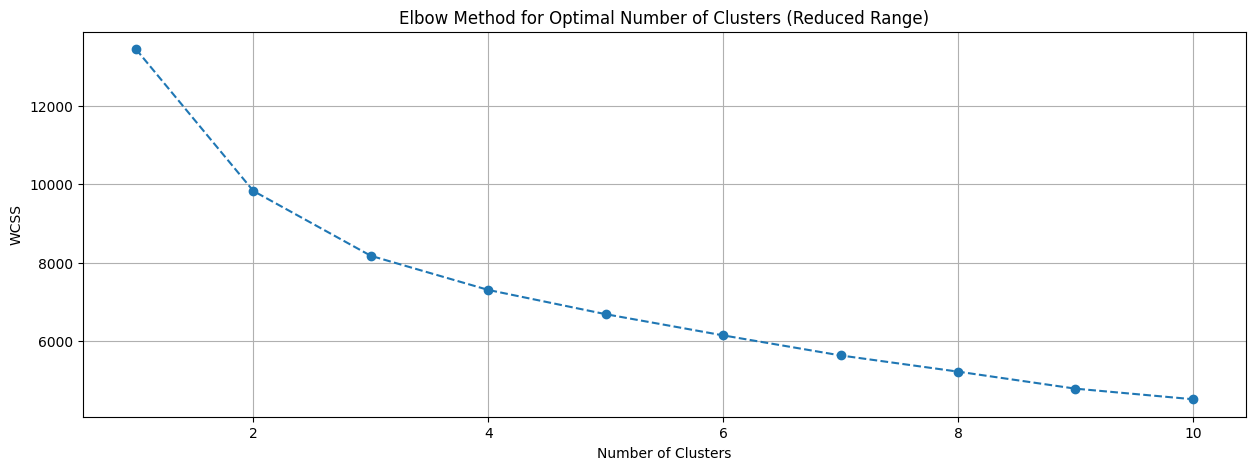

In [52]:
# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), wcss_reduced, marker='o', linestyle='--')

plt.title('Elbow Method for Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [53]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
kmeans.fit(furnish_scaled)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(furnish_scaled)

In [54]:
df['furnish_type'] = cluster_assignments

In [55]:
pd.set_option('display.max_colwidth', 120)

In [56]:
df[['furnishDetails', 'furnish_type']]

furnishDetails  \
0     ['1 wardrobe', '1 fan', '1 exhaust fan', '1 geyser', '1 light', '1 modular kitchen', '1 ac', '1 chimney', 'no bed', ...   
1     ['1 water purifier', '5 fan', '1 exhaust fan', '1 stove', '8 light', 'no ac', 'no bed', 'no chimney', 'no curtains',...   
2     ['10 bed', '3 fan', '10 geyser', '2 light', 'no ac', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan...   
3     ['1 water purifier', '21 fan', '1 fridge', '1 exhaust fan', '1 dining table', '21 geyser', '1 stove', '21 light', '1...   
4     ['1 water purifier', '1 fridge', '12 fan', '1 exhaust fan', '12 geyser', '1 stove', '12 light', '1 curtains', '12 wa...   
...                                                                                                                       ...   
1039  ['10 light', 'no ac', 'no bed', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan', 'no fan', 'no geys...   
1040                                                                                                                            
1041  ['6 fan', '20 light', 'no ac', 'no bed', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan', 'no geyse...   
1042  ['5 fan', '16 light', 'no ac', 'no bed', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan', 'no geyse...   
1043  ['1 water purifier', '10 fan', '1 fridge', '1 exhaust fan', '1 dining table', '5 geyser', '1 stove', '10 ac', '1 chi...   

      furnish_type  
0                0  
1                0  
2                0  
3                2  
4                2  
...            ...  
1039             0  
1040             0  
1041             0  
1042             0  
1043             2  

[1034 rows x 2 columns]

**furnish_type**

- `0` -> **unfurnished**
- `1` -> **semifurnished**
- `2` -> **furnished**

## General Steps - End

In [57]:
df.columns

Index(['property_name', 'link', 'society', 'price', 'rate', 'area',
       'areaWithType', 'bedRoom', 'bathroom', 'balcony', 'additionalRoom',
       'address', 'noOfFloor', 'facing', 'agePossession', 'nearbyLocations',
       'description', 'furnishDetails', 'features', 'rating', 'property_id',
       'plot_area', 'built_up_area', 'carpet_area', 'study room',
       'servant room', 'store room', 'pooja room', 'others', 'temp_sector',
       'sector', 'furnish_type'],
      dtype='object')

In [58]:
df.isnull().sum()

property_name        0
link                 0
society            581
price               76
rate                29
area                 0
areaWithType        57
bedRoom             57
bathroom            57
balcony             57
additionalRoom     445
address              0
noOfFloor           77
facing             361
agePossession        0
nearbyLocations      0
description          0
furnishDetails       0
features           360
rating             136
property_id          8
plot_area          255
built_up_area      743
carpet_area        850
study room           0
servant room         0
store room           0
pooja room           0
others               0
temp_sector          0
sector             130
furnish_type         0
dtype: int64

In [59]:
df.drop(
    columns=[
        'areaWithType',
        'additionalRoom',
        'address',
        'furnishDetails',
        'rating',
        'temp_sector',
    ],
    inplace=True,
)

In [60]:
pd.set_option('display.max_columns', None)
df.sample(5)

property_name  \
748  8 bedroom house for sale in sushant lok phase 1   
120    4 bedroom house for sale in sector 82 gurgaon   
514   5 bedroom house for sale in sector 37b gurgaon   
943         10 bedroom house for sale in dlf phase 3   
30     4 bedroom house for sale in sector 67 gurgaon   

                                                                                                                        link  \
748  https://www.99acres.com/8-bhk-bedroom-independent-house-villa-for-sale-in-sushant-lok-phase-1-gurgaon-25650-sq-ft-sp...   
120    https://www.99acres.com/4-bhk-bedroom-independent-house-villa-for-sale-in-sector-82-gurgaon-3240-sq-ft-spid-h69959306   
514  https://www.99acres.com/5-bhk-bedroom-independent-house-villa-for-sale-in-sector-37-b-gurgaon-1000-sq-ft-r1-spid-l65...   
943  https://www.99acres.com/10-bhk-bedroom-independent-house-villa-for-sale-in-dlf-pink-town-house-dlf-city-phase-3-gurg...   
30   https://www.99acres.com/4-bhk-bedroom-independent-house-villa-for-sale-in-ansal-api-esencia-sector-67-gurgaon-2259-s...   

                      society  price     rate     area  bedRoom  bathroom  \
748                       NaN  550.0   2716.0  1936.80      8.0       7.0   
120                       NaN  700.0  21605.0  3238.76      4.0       4.0   
514                       NaN   95.0   9500.0  1000.68      5.0       3.0   
943  dlf pink town house4.0 ★  190.0   3786.0  5014.16     10.0       9.0   
30     ansal api esencia3.7 ★  546.0  24170.0  2259.60      4.0       5.0   

     balcony  noOfFloor      facing   agePossession  \
748     -1.0        3.0        east  moderately old   
120     -1.0        1.0  north-east  Relatively New   
514      2.0        2.0        west  Relatively New   
943     -1.0        3.0       north  Relatively New   
30      -1.0        2.0        east  Relatively New   

                                                                                                             nearbyLocations  \
748  [huda city centre metro station, new life church, hanuman mandir, hdfc bank atm, standard chartered atm, hdfc atm, r...   
120  [orris community center, petrol pump indian oil, essar petrol pump, petrol pump indian oil, petrol pump, indian oil,...   
514  [shri balaji hospital and trauma center, kamla hospital gurgaon, yadav hospital gurgoan, chandna dental surgery orth...   
943  [dlf phase 3 metro station, micromax moulsari avenue metro station, dlf phase 2 metro station, guru dronacharya metr...   
30   [proposed metro corridor, n.h-8, golf course road, shiskshantar, dps, amity, pathways, gd goenka, medicity, artemis,...   

                                                                                                                 description  \
748  this is 215 sq yard independent well maintained duplex villa with basement\navailable on sale at c block sushant lok...   
120  1 360 sq. yd\n2park facing villa\n3 4 bhk\n4 (4) washrooms\n5 (2) kitchen\n # 100% power back-up\n360 sq. yd. 4 bhk ...   
514  interested to sell independent house/villa.placed at sector-37b gurgaon.nice unfurnished enhancing decorit has spaci...   
943  this property is available for sale in dlf ph-3 u block a good opportunity to investment for rental income total flo...   
30   ansal esencia is a residential group housing property designed by known ansal groups. this housing apartment is diff...   

                                                                                                                    features  \
748  ['private garden / terrace', 'water purifier', 'high ceiling height', 'maintenance staff', 'false ceiling lighting',...   
120  ['feng shui / vaastu compliant', 'private garden / terrace', 'maintenance staff', 'water storage', 'park', 'visitor ...   
514                                                                                                                      NaN   
943                            ['feng shui / vaastu compliant', 'private garden / terrace

## Export dataset

In [61]:
df.to_csv('data/processed/houses.csv', index=False)